# Initialize the environment

In [9]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [10]:
env = gym.make('CartPole-v1')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('State values high:', env.observation_space.high)
print('State values low:', env.observation_space.low)
print(env.observation_space)
print('Number of actions: ', env.action_space.n)


State shape:  (4,)
State values high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
State values low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Number of actions:  2



Here is a demo on how to interact with the env if you are unfamiliar with gym<br/>
episodes: number os games you want to play<br/>
max_steps: max number of actions you will perform in a game. This is to avoid the game going on indefinitely<br/>

First you start by calling env.reset() which initilises the env and returns the first state.<br/>
Get the action from the agent by passing the state.
env.step(action) performs the action and returns 4 things<br/>
1)The next state<br/>
2)reward obtained by performing that action<br/>
3)done - This is a boolean indicating if the game is over (eg agent has died)<br/>
         If True it means game is over and the next state it had returned is some garbage values<br/>
         If false it means agent is still playing<br/>
4)info - not important<br/><br/>
Calling env.render() displays the game as its being played. While training, do not call this as it will greatly
slow down training


In [14]:
episodes = 200
max_steps = 200
for i in range(episodes):
    state = env.reset()
    for j in range(max_steps):
        action = random.choice([0,1]) #choose random action
        env.render()
        time.sleep(0.01)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

# Make your agent

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [63]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size):
        """Build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            Build a Neural net with state_size no of inputs and action_size of outputs.
            Not necessary to make very deep network
    
        """
        super(QNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.fhl_units = 40
        self.shl_units = 30
        self.fhl = nn.Linear(state_size, self.fhl_units)
        self.shl = nn.Linear(self.fhl_units, self.shl_units)
        self.fl = nn.Linear(self.shl_units, action_size)
       
    
    def forward(self, state):
        """Define the foward function"""
        t = F.relu(self.fhl(state))
        t1 = F.relu(self.shl(t))
        action = self.fl(t1)
        return action

In [31]:
import numpy as np
import random
from collections import namedtuple, deque

In [75]:
BUFFER_SIZE = int(1e7)  # replay buffer size
BATCH_SIZE = 1000         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3                # learning rate 
UPDATE_EVERY = 8        # how often to update the network

#--------------------------------TO-DO------------------------------------------------------
#Vary all the params and report how the training is effected

In [70]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size


        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 1e-6
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        #-----------------------------------TO-DO---------------------------------------------------
        '''The action values predicted by the network are stored in action_values. Implement an epsilon greedy
           strategy to select the action you will perform'''#replace this with the chosen epsilon greedy action
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size)) 

    def learn(self, experiences, gamma):
        """Learn from experience and update network weights

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        #--------------------------TO-DO---------------------------------------------
        '''
        Compute Q targets for current states. 
        
        You have Q values of next states in Q_targets_next
        You have reward for the current state-actions stored in rewards
        Use these to compute the Q_targets.
        Remember, for terminal states, the next_states returned are actually garbage, so even their q values are
        meaningless but still stored in Q_targets_next. Figure out how to deal with them.
        '''
        Q_targets = self.qnetwork_target(states)*gamma*(1-dones) + rewards #Fill in here
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [71]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch

        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


# Train the agent

In [72]:
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

eps = 1                           # initialize epsilon - Fill this in
eps_decay = 0.99                  # Decay rate of epsilon - Fill this in
n_episodes = 500                  # No of training episodes - Fill this in
max_t = 500                       # Max number of steps per episode - Fill this in

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
agent = Agent(env.observation_space.shape[0],env.action_space.n)

Using cpu


In [76]:
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = agent.act(state, eps)
        print(action)
        
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        eps = max(eps*eps_decay, 0.01)
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    
    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
    if i_episode % 100 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
    if np.mean(scores_window)>=200.0:
        print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break

0
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
Episode 1	Average Score: 15.370
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
Episode 2	Average Score: 15.360
0
0
1
0
1
0
1
0
0
1
0
Episode 3	Average Score: 15.300
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
Episode 4	Average Score: 15.360
0
0
1
0
1
0
1
0
1
0
1
Episode 5	Average Score: 15.300
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
Episode 6	Average Score: 15.300
0
1
0
0
1
0
1
0
1
0
1
0
1
0
Episode 7	Average Score: 15.310
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
Episode 8	Average Score: 15.380
0
0
1
0
1
0
1
0
1
0
1
0
Episode 9	Average Score: 15.370
0
0
1
0
1
0
1
0
1
0
1
0
1
Episode 10	Average Score: 15.340
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
Episode 11	Average Score: 15.400
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
Episode 12	Average Score: 15.410
0
0
1
0
1
0
1
0
1
0
1
0
0
1
0
Episode 13	Average Score: 15.420
0
1
0
0
1
0
1
0
1
0
1
0
1
Episode 14	Average Score: 15.400
0
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 15	Average Score: 15.400
0
0
1
0
1
0
1
0
1
0
1
0
Episode 16	Average Score: 15.380
0
1
0
1
0
0
1
0

Episode 146	Average Score: 14.890
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 147	Average Score: 14.890
0
0
1
0
1
0
1
0
1
0
1
Episode 148	Average Score: 14.860
0
0
1
0
1
0
1
0
0
1
0
Episode 149	Average Score: 14.790
0
0
1
0
1
0
1
0
1
0
0
1
0
Episode 150	Average Score: 14.800
0
0
1
0
1
0
1
0
1
0
1
0
0
Episode 151	Average Score: 14.800
0
1
0
1
0
1
0
0
1
0
0
1
1
Episode 152	Average Score: 14.770
0
0
1
0
1
0
1
0
1
0
1
0
0
1
Episode 153	Average Score: 14.760
0
0
1
0
1
0
1
0
0
1
Episode 154	Average Score: 14.720
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 155	Average Score: 14.760
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
Episode 156	Average Score: 14.820
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 157	Average Score: 14.830
0
0
1
0
0
1
1
0
1
0
Episode 158	Average Score: 14.820
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 159	Average Score: 14.871
0
0
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
Episode 160	Average Score: 14.860
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
Episode 161	Average Score: 14.900
0
0
1
0
1
0
1
0
1
0
1
Episode 

0
1
0
1
0
1
0
1
0
1
0
Episode 298	Average Score: 14.660
0
0
1
0
1
0
1
0
1
0
1
Episode 299	Average Score: 14.640
0
1
0
1
0
0
1
0
1
0
1
0
1
Episode 300	Average Score: 14.56
0
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
Episode 301	Average Score: 14.560
0
0
1
0
1
0
1
0
1
0
0
1
0
Episode 302	Average Score: 14.540
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
Episode 303	Average Score: 14.530
0
0
1
0
1
0
1
0
1
0
1
Episode 304	Average Score: 14.470
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
Episode 305	Average Score: 14.510
0
0
1
0
1
0
1
0
1
0
Episode 306	Average Score: 14.440
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
Episode 307	Average Score: 14.520
0
0
1
0
1
0
1
0
1
0
1
Episode 308	Average Score: 14.500
0
0
1
0
1
0
1
0
1
0
1
0
1
Episode 309	Average Score: 14.530
0
0
1
0
1
0
1
0
1
0
1
Episode 310	Average Score: 14.490
0
0
1
0
1
0
1
0
1
0
0
1
0
Episode 311	Average Score: 14.460
0
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 312	Average Score: 14.450
0
0
1
0
1
0
1
0
1
0
1
0
0
Episode 313	Average Score: 14.440
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1

0
1
0
1
0
1
Episode 449	Average Score: 14.920
1
0
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
Episode 450	Average Score: 14.950
0
0
1
0
1
0
1
0
1
0
1
0
Episode 451	Average Score: 14.900
0
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 452	Average Score: 14.900
0
0
1
0
1
0
1
0
1
0
Episode 453	Average Score: 14.840
0
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 454	Average Score: 14.880
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
Episode 455	Average Score: 14.930
0
0
1
0
1
0
1
0
1
0
1
0
1
Episode 456	Average Score: 14.900
0
0
1
0
1
0
1
0
1
0
1
0
0
Episode 457	Average Score: 14.890
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
Episode 458	Average Score: 14.910
0
0
1
0
1
0
1
0
1
0
1
0
Episode 459	Average Score: 14.890
0
0
1
0
1
0
1
0
1
0
1
0
1
Episode 460	Average Score: 14.900
0
0
1
0
1
0
1
0
1
0
1
1
0
0
1
0
0
Episode 461	Average Score: 14.940
0
1
0
0
1
0
1
0
1
0
1
0
1
0
Episode 462	Average Score: 14.890
0
0
1
0
1
0
1
0
1
0
1
0
0
1
Episode 463	Average Score: 14.880
0
0
1
0
1
0
1
0
1
0
1
0
1
0
Episode 464	Average Score: 14.880
0
0
1
0
1
0
1
0
1
0


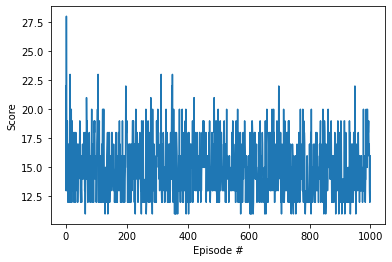

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()